# Data Preprocessing - Ryanair Customer Query Classification
### **Objective**: Clean and prepare the text data for machine learning models.
## **Key Steps:**
###  1. Text Cleaning & Normalization
###  2. Feature Engineering
###  3. Train/Validation Split
###  4. Text Vectorization
###  5. Data Export for Modeling

In [13]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import string
import json
import os
import pickle
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')
nltk.download('stopwords') 
nltk.download('wordnet')
nltk.download('omw-1.4')

# Download required NLTK data
nltk_downloads = ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger', 'omw-1.4', 'averaged_perceptron_tagger_eng']
for item in nltk_downloads:
    try:
        nltk.data.find(f'tokenizers/{item}')
    except LookupError:
        try:
            nltk.data.find(f'corpora/{item}')
        except LookupError:
            try:
                nltk.data.find(f'taggers/{item}')
            except LookupError:
                nltk.download(item, quiet=True)

print("All libraries imported successfully!")

All libraries imported successfully!


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\enes.ozyaramis\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\enes.ozyaramis\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\enes.ozyaramis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\enes.ozyaramis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\enes.ozyaramis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data

In [14]:
# Load datasets
print(" Loading Data...")
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
train_path = os.path.join(ROOT, 'data', 'raw', 'customer_queries_data.csv')
test_path  = os.path.join(ROOT, 'data', 'raw', 'customer_queries_test.csv')
train_data = pd.read_csv(train_path)
test_data  = pd.read_csv(test_path)
# Load EDA insights if available
try:
    with open('../reports/eda_insights.json', 'r') as f:
        eda_insights = json.load(f)
    print("EDA insights loaded successfully!")
except:
    print("EDA insights not found, proceeding without them")
    eda_insights = {}

print(f"Training data: {train_data.shape}")
print(f"Test data: {test_data.shape}")

 Loading Data...
EDA insights loaded successfully!
Training data: (20000, 2)
Test data: (5977, 1)


## 1. Initial Data Quality Check

In [16]:
# Check for missing values and basic stats
print(" Data Quality Check:")
print("=" * 30)
print("Missing values:")
print("Training:", train_data.isnull().sum().sum())
print("Test:", test_data.isnull().sum().sum())

print("\nDuplicate check:")
train_duplicates = train_data.duplicated().sum()
test_duplicates = test_data.duplicated().sum()
print(f"Training duplicates: {train_duplicates}")
print(f"Test duplicates: {test_duplicates}")

# Basic text statistics
train_data['query_length'] = train_data['query'].str.len()
train_data['word_count'] = train_data['query'].str.split().str.len()

print("\nText statistics:")
print(f"Avg query length: {train_data['query_length'].mean():.1f} chars")
print(f"Avg word count: {train_data['word_count'].mean():.1f} words")

 Data Quality Check:
Missing values:
Training: 0
Test: 0

Duplicate check:
Training duplicates: 0
Test duplicates: 1

Text statistics:
Avg query length: 71.8 chars
Avg word count: 12.9 words


In [17]:
test_data = test_data.drop_duplicates(subset=['query'], keep='first').reset_index(drop=True)

## 2. Text Cleaning Pipeline

In [18]:
class TextPreprocessor:
    """
    Advanced text preprocessing pipeline for customer queries.
    """
    
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer()
        
        # Custom stop words for airline domain
        airline_stopwords = {'flight', 'flights', 'ryanair', 'airline', 'customer', 'service'}
        self.stop_words.update(airline_stopwords)
        
    def clean_text(self, text):
        """Basic text cleaning."""
        if pd.isna(text):
            return ""
        
        # Convert to string and lowercase
        text = str(text).lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
        
        # Remove special characters but keep basic punctuation
        text = re.sub(r'[^a-zA-Z\s\.\!\?\,\'\"]', ' ', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def get_wordnet_pos(self, word):
        """Map POS tag to first character lemmatizer accepts."""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                   "N": wordnet.NOUN,
                   "V": wordnet.VERB,
                   "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    
    def advanced_tokenize(self, text):
        """Advanced tokenization with lemmatization."""
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove punctuation and short words
        tokens = [token for token in tokens if token.isalpha() and len(token) > 2]
        
        # Remove stop words
        tokens = [token for token in tokens if token not in self.stop_words]
        
        # Lemmatize
        tokens = [self.lemmatizer.lemmatize(token, self.get_wordnet_pos(token)) for token in tokens]
        
        return tokens
    
    def preprocess_text(self, text, method='lemmatize'):
        """Complete preprocessing pipeline."""
        # Clean text
        cleaned_text = self.clean_text(text)
        
        if method == 'basic':
            return cleaned_text
        
        elif method == 'lemmatize':
            tokens = self.advanced_tokenize(cleaned_text)
            return ' '.join(tokens)
        
        elif method == 'stem':
            tokens = self.advanced_tokenize(cleaned_text)
            stemmed_tokens = [self.stemmer.stem(token) for token in tokens]
            return ' '.join(stemmed_tokens)
        
        else:
            return cleaned_text

# Initialize preprocessor
preprocessor = TextPreprocessor()

print("Text preprocessor initialized!")

Text preprocessor initialized!


In [19]:
# %%
# Test preprocessing on sample data
print("Testing Preprocessing Pipeline:")
print("=" * 40)

sample_queries = [
    "I'm having trouble accessing my Ryanair customer account. How can I reset my password?",
    "Why was my credit card payment rejected???",
    "Can I change my flight date after booking",
    "The mobile app is not working for me, help!"
]

for i, query in enumerate(sample_queries, 1):
    print(f"\nSample {i}:")
    print(f"Original: {query}")
    print(f"Basic:    {preprocessor.preprocess_text(query, 'basic')}")
    print(f"Lemma:    {preprocessor.preprocess_text(query, 'lemmatize')}")


Testing Preprocessing Pipeline:

Sample 1:
Original: I'm having trouble accessing my Ryanair customer account. How can I reset my password?
Basic:    i'm having trouble accessing my ryanair customer account. how can i reset my password?
Lemma:    trouble access account reset password

Sample 2:
Original: Why was my credit card payment rejected???
Basic:    why was my credit card payment rejected???
Lemma:    credit card payment reject

Sample 3:
Original: Can I change my flight date after booking
Basic:    can i change my flight date after booking
Lemma:    change date book

Sample 4:
Original: The mobile app is not working for me, help!
Basic:    the mobile app is not working for me, help!
Lemma:    mobile app work help


## 3. Feature Engineering

In [20]:
def extract_text_features(df, text_column='query'):
    """Extract additional features from text."""
    features = pd.DataFrame()
    
    # Basic length features
    features['char_count'] = df[text_column].str.len()
    features['word_count'] = df[text_column].str.split().str.len()
    features['sentence_count'] = df[text_column].str.count(r'[.!?]+') + 1
    
    # Punctuation features
    features['question_marks'] = df[text_column].str.count('\?')
    features['exclamation_marks'] = df[text_column].str.count('!')
    features['comma_count'] = df[text_column].str.count(',')
    
    # Uppercase features
    features['caps_count'] = df[text_column].str.count(r'[A-Z]')
    features['caps_ratio'] = features['caps_count'] / features['char_count']
    
    # Average word length
    features['avg_word_length'] = df[text_column].apply(
        lambda x: np.mean([len(word) for word in str(x).split()]) if pd.notna(x) else 0
    )
    
    # Airline-specific keywords
    airline_keywords = ['flight', 'booking', 'ticket', 'baggage', 'seat', 'payment', 'refund', 'cancel']
    for keyword in airline_keywords:
        features[f'has_{keyword}'] = df[text_column].str.lower().str.contains(keyword, na=False).astype(int)
    
    return features

# Extract features for training data
print(" Extracting Features...")
text_features = extract_text_features(train_data)
print(f" Extracted {text_features.shape[1]} text features")

# Display feature statistics
print("\n Feature Statistics:")
print(text_features.describe())

 Extracting Features...
 Extracted 17 text features

 Feature Statistics:
        char_count  word_count  sentence_count  question_marks  \
count  5000.000000  5000.00000     5000.000000     5000.000000   
mean     71.799600    12.91640        2.245800        1.063800   
std      31.043257     5.35854        0.493793        0.377038   
min      22.000000     4.00000        1.000000        0.000000   
25%      52.000000     9.00000        2.000000        1.000000   
50%      61.000000    11.00000        2.000000        1.000000   
75%      81.000000    15.00000        2.000000        1.000000   
max     261.000000    44.00000        5.000000        3.000000   

       exclamation_marks  comma_count   caps_count   caps_ratio  \
count        5000.000000  5000.000000  5000.000000  5000.000000   
mean            0.002600     0.181600     2.805800     0.041978   
std             0.050929     0.476095     1.377413     0.020930   
min             0.000000     0.000000     1.000000     0.007576

## 4. Apply Preprocessing to All Data

In [21]:
# Apply preprocessing to training data
print("Preprocessing Training Data...")

# Create different versions of processed text
train_processed = train_data.copy()
train_processed['query_cleaned'] = train_data['query'].apply(
    lambda x: preprocessor.preprocess_text(x, 'basic')
)
train_processed['query_lemmatized'] = train_data['query'].apply(
    lambda x: preprocessor.preprocess_text(x, 'lemmatize')
)

# Add text features
for col in text_features.columns:
    train_processed[col] = text_features[col]

print(f"Training data processed: {train_processed.shape}")

# Apply preprocessing to test data
print(" Preprocessing Test Data...")
test_processed = test_data.copy()
test_processed['query_cleaned'] = test_data['query'].apply(
    lambda x: preprocessor.preprocess_text(x, 'basic')
)
test_processed['query_lemmatized'] = test_data['query'].apply(
    lambda x: preprocessor.preprocess_text(x, 'lemmatize')
)

# Add text features to test data
test_text_features = extract_text_features(test_data)
for col in test_text_features.columns:
    test_processed[col] = test_text_features[col]

print(f" Test data processed: {test_processed.shape}")

Preprocessing Training Data...
Training data processed: (5000, 22)
 Preprocessing Test Data...
 Test data processed: (999, 20)


## 5. Data Analysis After Preprocessing

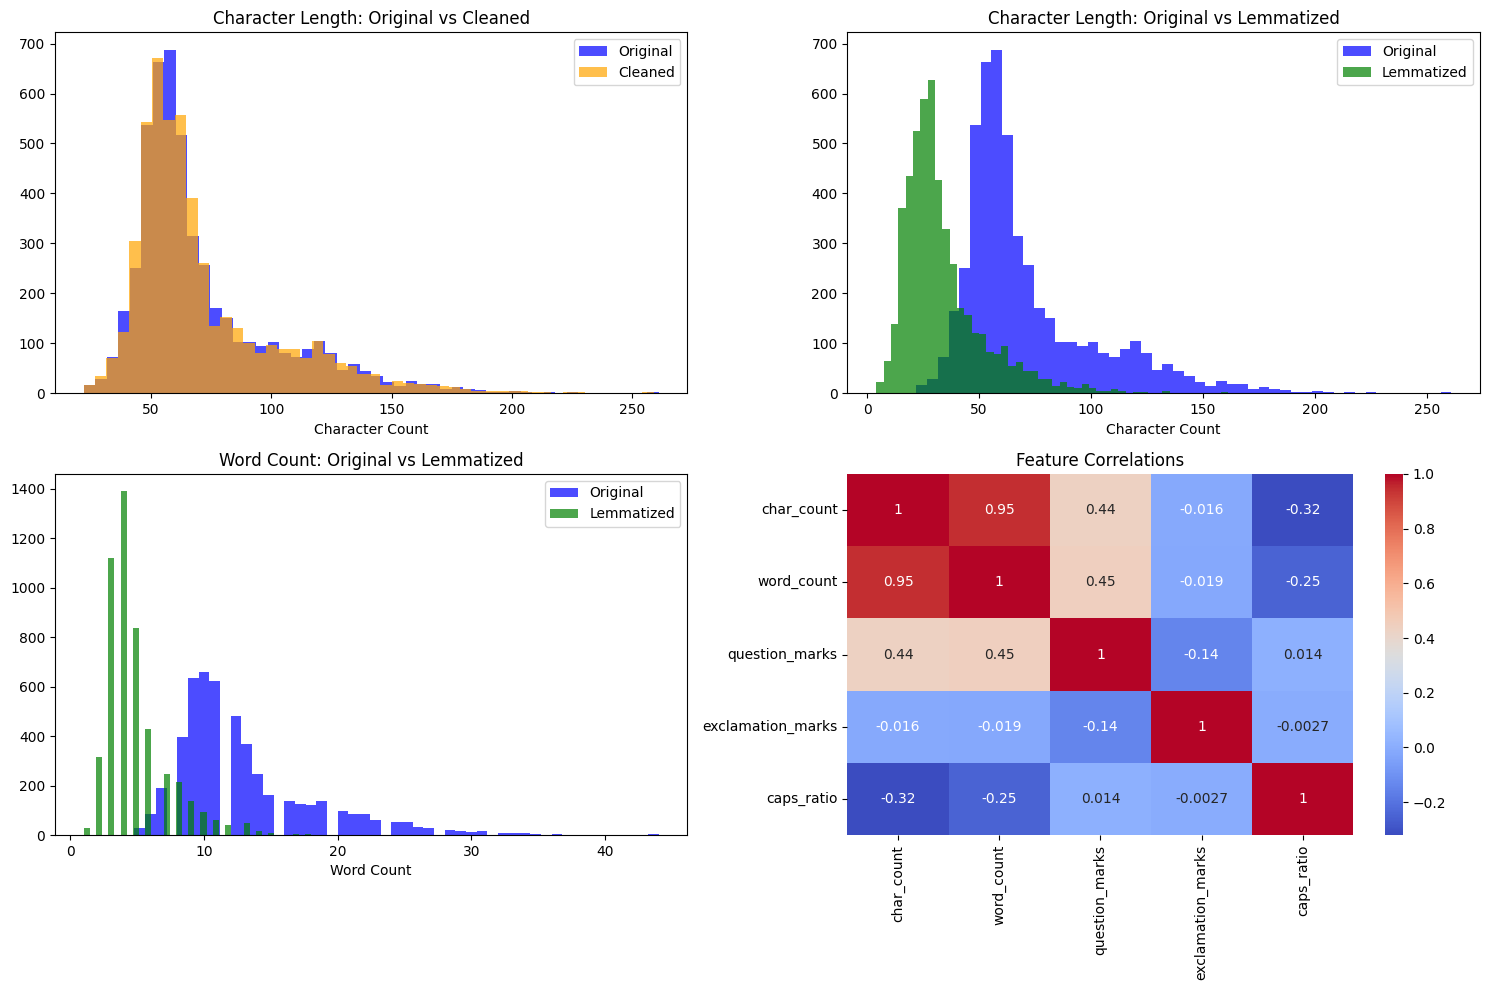

In [22]:
# %%
# Compare text lengths before and after preprocessing
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Original vs cleaned lengths
original_lengths = train_data['query'].str.len()
cleaned_lengths = train_processed['query_cleaned'].str.len()
lemmatized_lengths = train_processed['query_lemmatized'].str.len()

axes[0, 0].hist(original_lengths, bins=50, alpha=0.7, label='Original', color='blue')
axes[0, 0].hist(cleaned_lengths, bins=50, alpha=0.7, label='Cleaned', color='orange')
axes[0, 0].set_title('Character Length: Original vs Cleaned')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].legend()

axes[0, 1].hist(original_lengths, bins=50, alpha=0.7, label='Original', color='blue')
axes[0, 1].hist(lemmatized_lengths, bins=50, alpha=0.7, label='Lemmatized', color='green')
axes[0, 1].set_title('Character Length: Original vs Lemmatized')
axes[0, 1].set_xlabel('Character Count')
axes[0, 1].legend()

# Word count comparison
original_words = train_data['query'].str.split().str.len()
lemmatized_words = train_processed['query_lemmatized'].str.split().str.len()

axes[1, 0].hist(original_words, bins=50, alpha=0.7, label='Original', color='blue')
axes[1, 0].hist(lemmatized_words, bins=50, alpha=0.7, label='Lemmatized', color='green')
axes[1, 0].set_title('Word Count: Original vs Lemmatized')
axes[1, 0].set_xlabel('Word Count')
axes[1, 0].legend()

# Feature correlation heatmap
feature_cols = ['char_count', 'word_count', 'question_marks', 'exclamation_marks', 'caps_ratio']
correlation_matrix = train_processed[feature_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes[1, 1])
axes[1, 1].set_title('Feature Correlations')

plt.tight_layout()
plt.savefig('../reports/figures/preprocessing_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Train/Validation Split

In [23]:
# %%
# Prepare data for modeling
print("Preparing Data for Modeling...")

# Encode labels
label_encoder = LabelEncoder()
train_processed['label_encoded'] = label_encoder.fit_transform(train_processed['label'])

# Create train/validation split (stratified)
X = train_processed['query_lemmatized']  # Use lemmatized text as primary feature
y = train_processed['label_encoded']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print(f"Data split completed:")
print(f"   Training: {len(X_train):,} samples")
print(f"   Validation: {len(X_val):,} samples")
print(f"   Test: {len(test_processed):,} samples")

# Verify class distribution is maintained
print("\nClass Distribution Verification:")
original_dist = pd.Series(y).value_counts(normalize=True).sort_index()
train_dist = pd.Series(y_train).value_counts(normalize=True).sort_index()
val_dist = pd.Series(y_val).value_counts(normalize=True).sort_index()

print("Distribution maintained " if np.allclose(original_dist, train_dist, atol=0.01) else "Distribution issue ⚠️")

Preparing Data for Modeling...
Data split completed:
   Training: 4,000 samples
   Validation: 1,000 samples
   Test: 999 samples

Class Distribution Verification:
Distribution maintained 


## 7. Export Processed Data

In [24]:
# %%
# Save processed datasets
print("Saving Processed Data...")

# Create processed data directory
import os
os.makedirs('../data/processed', exist_ok=True)

# Save training splits
train_split_data = pd.DataFrame({
    'query_original': X_train.reset_index(drop=True),
    'label_encoded': y_train.reset_index(drop=True)
})

val_split_data = pd.DataFrame({
    'query_original': X_val.reset_index(drop=True),
    'label_encoded': y_val.reset_index(drop=True)
})

# Save to CSV
train_split_data.to_csv('../data/processed/train_split.csv', index=False)
val_split_data.to_csv('../data/processed/val_split.csv', index=False)
test_processed[['query_lemmatized']].to_csv('../data/processed/test_processed.csv', index=False)

# Save full processed datasets
train_processed.to_csv('../data/processed/train_processed.csv', index=False)
test_processed.to_csv('../data/processed/test_processed.csv', index=False)

# Save label encoder
with open('../data/processed/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Save preprocessing artifacts
preprocessing_info = {
    'label_classes': label_encoder.classes_.tolist(),
    'n_classes': len(label_encoder.classes_),
    'train_size': len(X_train),
    'val_size': len(X_val),
    'test_size': len(test_processed),
    'preprocessing_method': 'lemmatized',
    'feature_columns': text_features.columns.tolist()
}

with open('../data/processed/preprocessing_info.json', 'w') as f:
    json.dump(preprocessing_info, f, indent=2)

print("All processed data saved successfully!")

Saving Processed Data...
All processed data saved successfully!


## 8. Preprocessing Summary

In [25]:
# %%
print("PREPROCESSING SUMMARY:")
print("=" * 50)
print(f"Original training data: {len(train_data):,} samples")
print(f"Processed training data: {len(train_processed):,} samples")
print(f"Training split: {len(X_train):,} samples")
print(f"Validation split: {len(X_val):,} samples")
print(f"Test data: {len(test_processed):,} samples")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Text features extracted: {len(text_features.columns)}")

print(f"\nPreprocessing Steps Applied:")
print("   - Text cleaning and normalization")
print("   - Tokenization and lemmatization")
print("   - Stop word removal")
print("   - Feature engineering (text statistics)")
print("   - Stratified train/validation split")
print("   - Label encoding")

print(f"\nFiles Saved:")
print("   - ../data/processed/train_processed.csv")
print("   - ../data/processed/test_processed.csv") 
print("   - ../data/processed/train_split.csv")
print("   - ../data/processed/val_split.csv")
print("   - ../data/processed/label_encoder.pkl")
print("   - ../data/processed/preprocessing_info.json")

# Display sample of processed data
print(f"\nSample Processed Data:")
sample_df = pd.DataFrame({
    'Original': train_data['query'].head(3),
    'Cleaned': train_processed['query_cleaned'].head(3),
    'Lemmatized': train_processed['query_lemmatized'].head(3),
    'Label': train_data['label'].head(3)
})

for i, row in sample_df.iterrows():
    print(f"\nSample {i+1}:")
    print(f"Original:   {row['Original']}")
    print(f"Lemmatized: {row['Lemmatized']}")
    print(f"Label:      {row['Label']}")

PREPROCESSING SUMMARY:
Original training data: 5,000 samples
Processed training data: 5,000 samples
Training split: 4,000 samples
Validation split: 1,000 samples
Test data: 999 samples
Number of classes: 30
Text features extracted: 17

Preprocessing Steps Applied:
   - Text cleaning and normalization
   - Tokenization and lemmatization
   - Stop word removal
   - Feature engineering (text statistics)
   - Stratified train/validation split
   - Label encoding

Files Saved:
   - ../data/processed/train_processed.csv
   - ../data/processed/test_processed.csv
   - ../data/processed/train_split.csv
   - ../data/processed/val_split.csv
   - ../data/processed/label_encoder.pkl
   - ../data/processed/preprocessing_info.json

Sample Processed Data:

Sample 1:
Original:   I'm having trouble accessing my Ryanair customer account. How can I reset my password or recover my account?
Lemmatized: trouble access account reset password recover account
Label:      Customer Account Issues

Sample 2:
Origi